# K-Means Clustering

Fundamentally, clustering is a class of __unsupervised machine learning__ algorithms, and KMeans (the most straightforward implementation is also called Lloyd's algorithm) follows these steps to assign points in a dataset to one of k clusters that we specify as an argument to `KMeans()`:

1. Random initialisation of centroids (or in the case of K-means++, a weighted probability distribution is used to choose the centroids to arrive at more spread out centroids)
2. Assign each point in the entire dataset to one cluster (c.f. fuzzy/soft clustering) such that the distance metric Within Cluster Sum of Squares (WCSS) is minimal
3. Assign the mean of points in the resulting clusters as the new centroid
4. Iterate: repeat steps 2 and 3 until convergence (or specified number of iterations)

Essentially, the function to be minimised (i.e. the cost function denoted by $J$ ) is derived from the Within Cluster Sum of Squares (WCSS) metric and [minimised via coordinate descent](http://kldavenport.com/the-cost-function-of-k-means/):

<img src="https://www.packtpub.com/sites/default/files/Article-Images/8365OS_06_04.png" align="center" style="width: 200px;"/>

In the case of KMeans, this is equivalent to minimising the Euclidean distance. Modifications to the 'vanilla' KMeans algorithm exist that allow the use of other distance metrics.

Now that we've covered the basic theory, let's move on to its application.

### Importing libraries.

We will be using `StandardScaler()` to transform our data prior to passing it through `cluster.KMeans()`. Why is this a good idea? Because KMeans clusters tend to be isotropic (intuitively, roughly spherical), if the existing features are not of a comparable scale and/or have very different variances, the resulting clusters are liable to be separated more along variables with greater variance.

Another nuance of KMeans is the clustering results might be different from one run to another. This is because of the random initialisation of centroids, and another reason may be the ordering of categorical variables which have no clear ordinal relationship. It may be worth running KMeans a few times to see with different ordering of such variables, and using a fixed seed with the `random_state` to ensure consistency.

In [1]:
%matplotlib inline 

import pandas as pd
import numpy as np
from sklearn import cluster, metrics
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot') 
from sklearn import datasets

###  Data loading.

We are going to use K-means clustering to assign class labels to the Wisconsin breast cancer dataset, which conveniently comes with scikit-learn.

In [2]:
bc = datasets.load_breast_cancer()

In [3]:
df = pd.DataFrame(bc.data,columns=bc.feature_names)

In [4]:
print df.shape
pd.set_option('max_columns', len(df.columns))
df.head(2)

(569, 30)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902


In [5]:
df.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,0.405172,1.216853,2.866059,40.337079,0.007041,0.025478,0.031894,0.011796,0.020542,0.003795,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,0.277313,0.551648,2.021855,45.491006,0.003003,0.017908,0.030186,0.006170,0.008266,0.002646,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,0.111500,0.360200,0.757000,6.802000,0.001713,0.002252,0.000000,0.000000,0.007882,0.000895,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,0.232400,0.833900,1.606000,17.850000,0.005169,0.013080,0.015090,0.007638,0.015160,0.002248,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,0.324200,1.108000,2.287000,24.530000,0.006380,0.020450,0.025890,0.010930,0.018730,0.003187,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,0.478900,1.474000,3.357000,45.190000,0.008146,0.032450,0.042050,0.014710,0.023480,0.004558,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,2.873000,4.885000,21.980000,542.200000,0.031130,0.135400,0.396000,0.052790,0.078950,0.029840,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


Looks like we have a very clean dataset! However as you can see, our features have very different scales and variances that would significantly affect the outcome of KMeans clustering. Time to apply standardisation.

### Standardisation.

Concretely, standardisation recentres our features around a mean of zero, and one standard deviation as the unit scale. `sklearn.preprocessing` implements the handy function `StandardScaler()` that makes doing this a simple as these few lines of code:

In [6]:
ss = StandardScaler() # we instantiate it as a matter of good practice
data_scaled = ss.fit_transform(df)

In [7]:
kmeans = cluster.KMeans(n_clusters=2, random_state=42)
kmeans.fit(data_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

And that's it! The algorithm has already done its job. Now we want to examine the cluster centres and labels:

In [8]:
centroids = kmeans.cluster_centers_
labels = kmeans.labels_
print centroids[0]
print labels[0:10]

[ 0.97397614  0.48151381  1.0066346   0.96352718  0.60925407  1.020696
  1.13942935  1.16458212  0.61113855  0.25222982  0.85859633  0.04274078
  0.86027888  0.8071077   0.01706063  0.69505052  0.63689512  0.77623856
  0.14038222  0.41503212  1.04008365  0.50631048  1.06597067  1.00315418
  0.60829274  0.95083725  1.04429844  1.14621103  0.59741617  0.62246932]
[0 0 0 0 0 0 0 0 0 0]


As if now we'll leave it as an array of numbers; we'll use data visualisation further below to see what our clusters look like.

### Evaluation. 

While KMeans is normally used in supervised machine learning problems, for the purposes of this project we're just trying to understand how it works. So we'll be comparing the resulting clusters with the true labels from the dataset. 

We'll be looking at the accuracy score, the classification report, the confusion matrix and the **silhouette score**. Let's see if our cluster labels are the same as the ground truth!

In [9]:
metrics.accuracy_score(bc.target, labels)

0.91036906854130051

In [10]:
print metrics.classification_report(bc.target, labels)

             precision    recall  f1-score   support

          0       0.93      0.83      0.87       212
          1       0.90      0.96      0.93       357

avg / total       0.91      0.91      0.91       569



Not too bad on the face of it! Of course, all metrics need comparison to make any sense, and this is not a rigorous evaluation that compares it to other clustering algorithms. Let's turn these numbers into a nice graphical confusion matrix:

Confusion matrix, without normalisation
[[175  37]
 [ 14 343]]
Normalised confusion matrix
[[ 0.83  0.17]
 [ 0.04  0.96]]


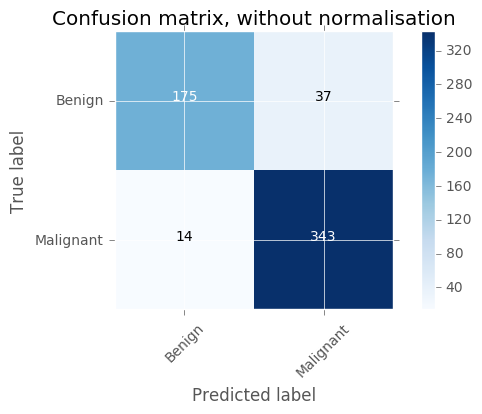

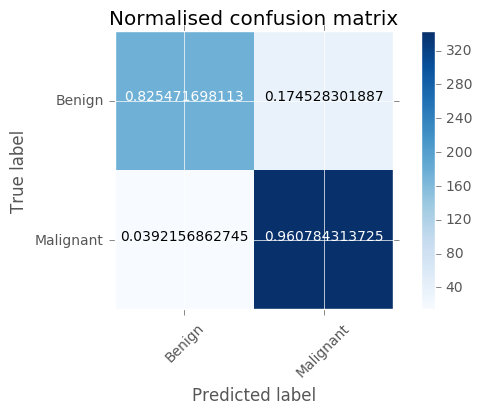

In [11]:
# helper functions from sklearn docs
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalised confusion matrix")
    else:
        print('Confusion matrix, without normalisation')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cnf_matrix = metrics.confusion_matrix(bc.target, labels)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["Benign","Malignant"],
                      title='Confusion matrix, without normalisation')

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["Benign","Malignant"], normalize=True,
                      title='Normalised confusion matrix')

plt.show()

### Silhouette score.

The silhouette score (or coefficient) of a data point measures of how similar it is to its own cluster (cohesion) compared its neighbouring clusters (separation). Its value ranges from -1 to 1, with higher values indicating that the data point matches well to its own cluster and not to its neighbouring clusters, and vice versa. The score of a cluster is the average of the score of all its constituent points, and the overall score is the average of all the clusters' scores. The score can be calculated using any distance metric, such as the Euclidean distance (L2), the Manhattan distance (L1), and the Minkowski distance generalised to n-dimensions.

If the overall silhouette score is high, then the clustering is judged to have been done successfully. On the other hand, a low value may indicate that there too many or too few clusters, which in the case of KMeans would mean adjusting the value of k. However, it might also be the distribution of the data points itself that makes it unsuited for KMeans clustering. Alternative clustering algorithms such as DBSCAN and Hierarchical clustering may be more appropriate. The key is to understand the underlying structure of our data, and visualisation is essential to help us develop a clearer picture.

In [12]:
print "The Silhouette score for k=2 is:",metrics.silhouette_score(data_scaled,labels)

The Silhouette score for k=2 is: 0.344974005103


How does the silhouette score vary with the number of clusters for this particular dataset? As we see below, it actually decreases with increasing values of k. Plotting these curves is one way to judge the results of our clustering, but nothing beats looking at the data itself visually.

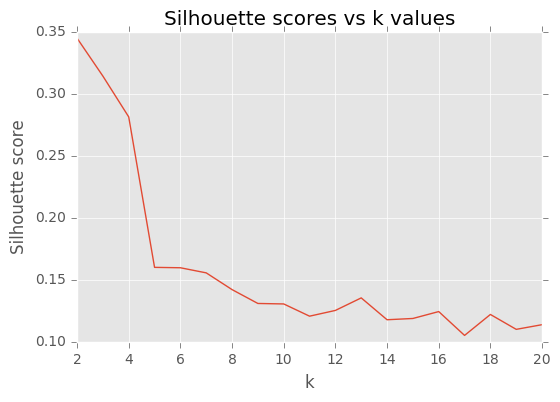

In [13]:
silhouette_scores = [None,None]
for i in range(2,21):
    kmeans = cluster.KMeans(n_clusters=i)
    kmeans.fit(data_scaled)
    labels_ = kmeans.labels_
    score = metrics.silhouette_score(data_scaled, labels_)
    silhouette_scores.append(score)
plt.plot(silhouette_scores)
plt.title("Silhouette scores vs k values")
plt.ylabel("Silhouette score")
plt.xlabel("k")
plt.show()

### Comparing cluster labels.

Now let's visualise the differences between the true labels and what KMeans came up with. We will set the random state for the algorithm to ensure consistency.

In [14]:
kmeans = cluster.KMeans(n_clusters=2, random_state=42)
kmeans.fit(df)
centroids = kmeans.cluster_centers_
labels = kmeans.labels_

In [15]:
true1 = [True if i==1 else False for i in labels.tolist()]
true0 = [True if i==0 else False for i in labels.tolist()]

In [16]:
true1y = [True if i==1 else False for i in bc.target]
true0y = [True if i==0 else False for i in bc.target]

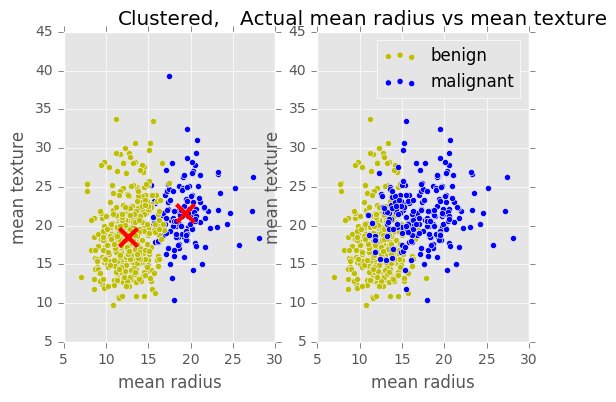

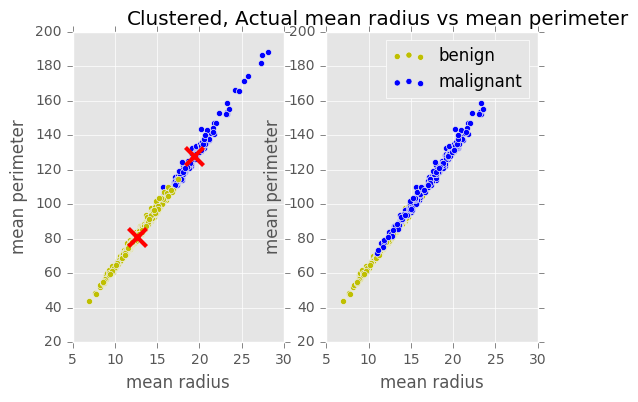

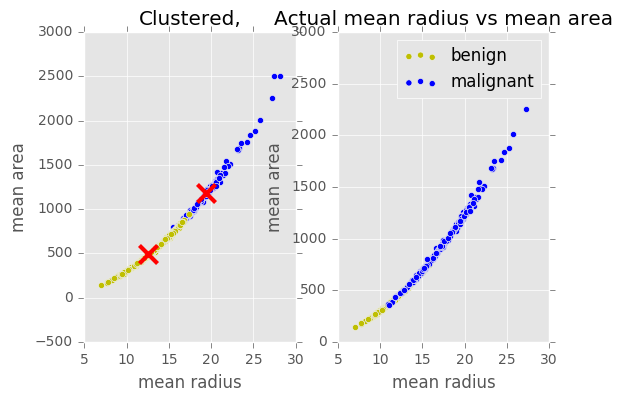

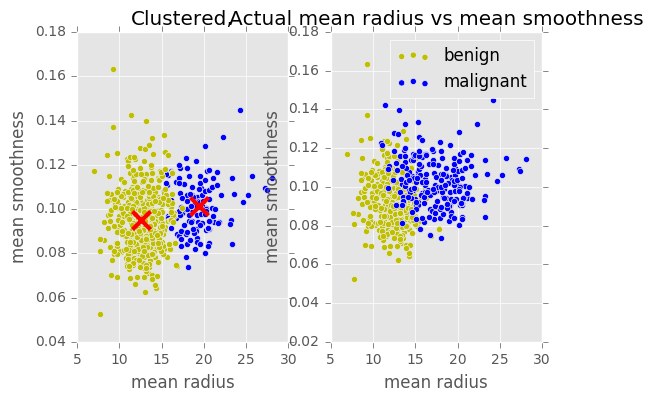

In [22]:
count = 0
for m,i in enumerate(df.columns.tolist()):
    for n,j in enumerate(df.columns.tolist()):
        if i!=j and count <4:
            fig = plt.figure()
            
            ax1 = fig.add_subplot(121)
            ax1.scatter(df[true1][i],df[true1][j], c="b")
            ax1.scatter(df[true0][i],df[true0][j], c="y")
            ax1.scatter(centroids[:, m], centroids[:, n],
                        marker='x', s=169, linewidths=3,
                        color='r', zorder=10)
            title1 = "Clustered,"
            ax1.set_title(title1)
            ax1.set_xlabel(i)
            ax1.set_ylabel(j)
            
            ax2 = fig.add_subplot(122)
            ax2.scatter(df[true1y][i],df[true1y][j], c="y")
            ax2.scatter(df[true0y][i],df[true0y][j], c="b")
            title2 = "Actual "+ i + " vs " + j
            ax2.set_title(title2)
            ax2.set_xlabel(i)
            ax2.set_ylabel(j)

            plt.legend(['benign','malignant'])
            plt.show()
            count += 1

The red crosses on the left mark the centroids. There's quite a difference between our KMeans clusters and the true labels!